# Zarr SODA 3.4.2 ds

In [200]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [201]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.e149665894e84363accffaeef72899bd Dashboard: /services/dask-gateway/clusters/prod.e149665894e84363accffaeef72899bd/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline
xr.set_options(display_style='text');

In [2]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
url_transport = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_10dy_transport_or'
#url_ice = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ice_or'

fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)
transport = xr.open_zarr(fs.get_mapper(url_transport), consolidated=True)
#ice = xr.open_zarr(fs.get_mapper(url_ice), consolidated=True)

In [157]:
import xgcm

grid_ocean = xgcm.Grid(ocean, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [164]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

## Variables to create:

- [ ] Vel terms for psi
- [ ] Surf flux term (incl. sw penetration)
- [ ] Total tendency term

## <font color='Green'>Get cell area and volume in meters</font>

In [120]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [159]:
#converting lat from degrees to meters
delta_lat = grid_ocean.diff(ocean.yt_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid_ocean.diff(ocean.yu_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ocean.diff(ocean.xt_ocean, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ocean.yt_ocean))
delta_lon_u = grid_ocean.diff(ocean.xu_ocean, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(ocean.yu_ocean))

In [160]:
dx

<xarray.DataArray (xu_ocean: 1440, yt_ocean: 1070)>
array([[4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       ...,
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95

In [161]:
dx_u

<xarray.DataArray (xt_ocean: 1440, yu_ocean: 1070)>
array([[4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       ...,
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.79 89.89 90.0

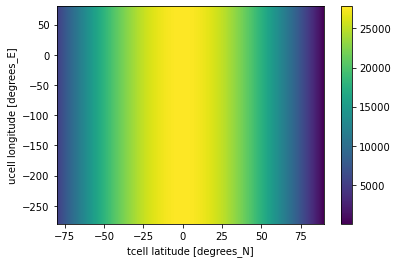

In [162]:
dx.plot()

In [163]:
dz = grid_ocean.diff(ocean.st_edges_ocean[1:], 'Z', boundary='fill', fill_value=0.)
dz_u = grid_ocean.diff(ocean.sw_edges_ocean[1:], 'Zu', boundary='fill', fill_value=0.)

In [166]:
cell_elements = xr.merge([dx.rename('dx'), dx_u.rename('dx_u'), 
                          dy.rename('dy'), dy_u.rename('dy_u'), 
                          dz.rename('dz'), dz_u.rename('dz_u')])

In [167]:
cell_elements

<xarray.Dataset>
Dimensions:   (st_ocean: 50, sw_ocean: 50, xt_ocean: 1440, xu_ocean: 1440, yt_ocean: 1070, yu_ocean: 1070)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.79 89.89 90.0
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_ocean  (sw_ocean) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
Data variables:
    dx        (xu_ocean, yt_ocean) float64 4.817e+03 4.868e+03 ... 76.81 25.58
    dx_u      (xt_ocean, yu_ocean) float64 4.842e+03 4.893e+03 ... 1.702e-12
    dy        (yu_ocean) float64 1.174e+04 1.174e+04 1.174e+04 ... 1.174e+04 nan
    dy_u      (yt_ocean) float64 nan 1.174e+04 1.174e+04 ... 1.174e+04 1.173e+04
    dz        (st_ocean) float64 10.09 10.13 10.18 ... 209.9 209.9 -5.5e+03
    dz_u      (sw_ocean) float64 10.12 10.14 10.22 ... 209.9 105.0 -5.5e+03

## <font color='Green'>Slice to WG region</font>

In [80]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [83]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [170]:
ocean_wg = ocean.isel(**lat_range, **lon_range)
transport_wg = transport.isel(**lat_range, **lon_range)
cells_wg = cell_elements.isel(**lat_range, **lon_range)

In [223]:
import xgcm

grid_ocean_wg = xgcm.Grid(ocean_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

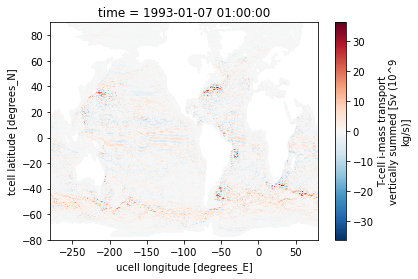

In [171]:
transport.tx_int[0].plot()

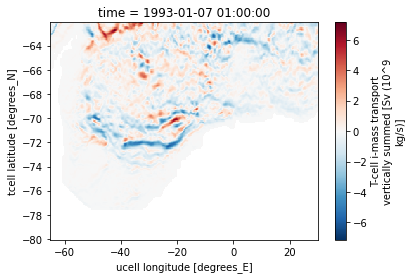

In [172]:
transport_wg.tx_int[0].plot()

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

In [182]:
transport_wg.tx_trans.isel(xu_ocean=-1)

<xarray.DataArray 'tx_trans' (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float32, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_t
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.0000000200408773e+20, 1.0000000200408773e+20]

In [178]:
cells_wg.dz.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [181]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [184]:
transport_wg.ty_trans.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.31 -62.2 -62.08

In [188]:
cells_wg.dx_u.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.31 -62.2 -62.08

In [190]:
u_transport_right = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=-1)
u_transport_left = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=0)

v_transport = (transport_wg.ty_trans * cells_wg.dz * cells_wg.dx_u).isel(yu_ocean=-1)

In [217]:
ocean_wg.wt[0].coords

Coordinates:
  * sw_ocean  (sw_ocean) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [220]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [224]:
dx_interp = grid_ocean_wg.interp(cells_wg.dx_u, 'Y', boundary='fill')

In [226]:
dx_interp.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [227]:
w_transport = (ocean_wg.wt * dx_interp * cells_wg.dy_u).isel(sw_ocean=0)

In [245]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

#surf_transport = (ocean_wg.net_heating * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass)
surf_transport = ocean_wg.net_heating  / (heat_capacity_cp * runit2mass)

In [194]:
u_transport_left[0]

<xarray.DataArray (st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(50, 169), dtype=float64, chunksize=(50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    time      object 1993-01-07 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

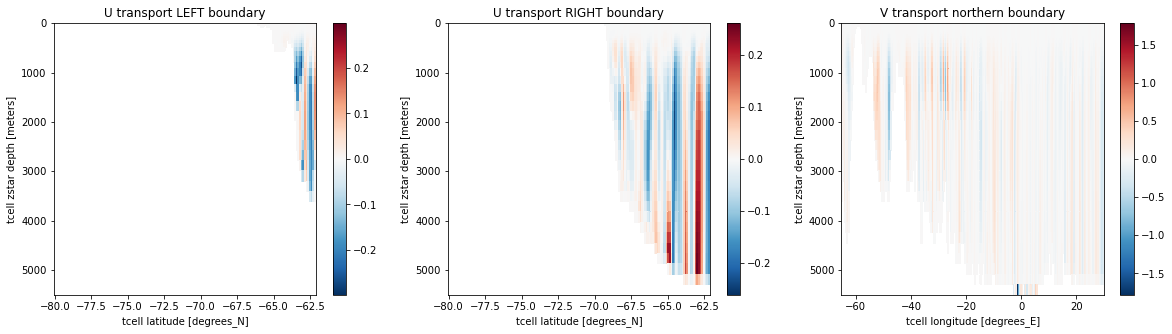

In [198]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [202]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.e149665894e84363accffaeef72899bd Dashboard: /services/dask-gateway/clusters/prod.e149665894e84363accffaeef72899bd/status,Cluster Workers: 8 Cores: 16 Memory: 68.72 GB


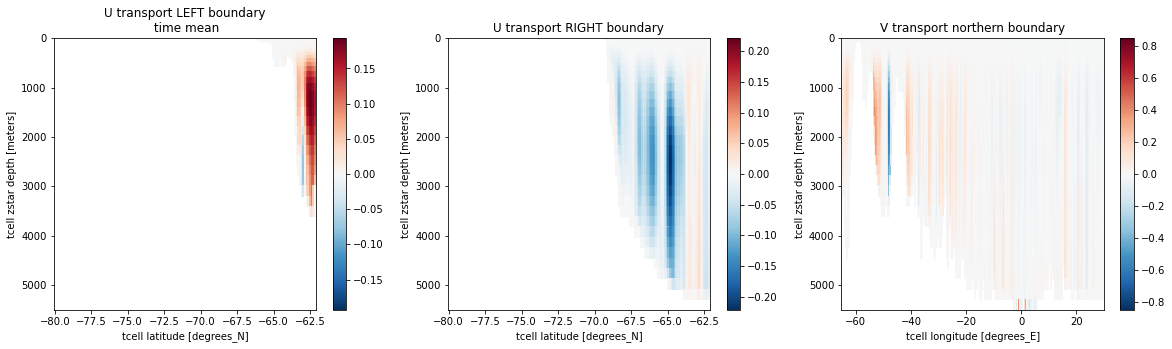

In [203]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary\n time mean')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [204]:
u_transport_right

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [205]:
u_transport_left

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [206]:
v_transport

<xarray.DataArray (time: 985, st_ocean: 50, xt_ocean: 381)>
dask.array<getitem, shape=(985, 50, 381), dtype=float64, chunksize=(1, 50, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    yu_ocean  float64 -62.08

In [228]:
w_transport

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    sw_ocean  float64 10.07
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [243]:
surf_transport

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [207]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-69.76946809)

In [208]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(71.82896706)
Coordinates:
    yu_ocean  float64 -62.08

In [229]:
w_transport_mean_value = (w_transport).fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(0.85836276)
Coordinates:
    sw_ocean  float64 10.07

In [248]:
surf_transport_mean_value = surf_transport.fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')
surf_transport_mean_value.load()

<xarray.DataArray 'net_heating' ()>
array(-0.18487322, dtype=float32)

In [250]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
residual

<xarray.DataArray ()>
array(2.05949897)
Coordinates:
    yu_ocean  float64 -62.08

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [252]:
ocean_wg.salt_flux_total

<xarray.DataArray 'salt_flux_total' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      sfc_salt_flux_total
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg/(m^2*sec)
    valid_range:    [-10000.0, 10000.0]

In [256]:
ocean_wg.hflux_total

<xarray.DataArray 'hflux_total' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      surface heat flux from coupler plus restore (omits mass t...
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Watts/m^2
    valid_range:    [-10000.0, 10000.0]

In [260]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (ocean_wg.hflux_total * dx_interp * dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (ocean_wg.salt_flux_total * dx_interp * dy_u) / runit2mass # psu*m^3/s

In [261]:
surf_flux_th

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

In [262]:
surf_flux_slt

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

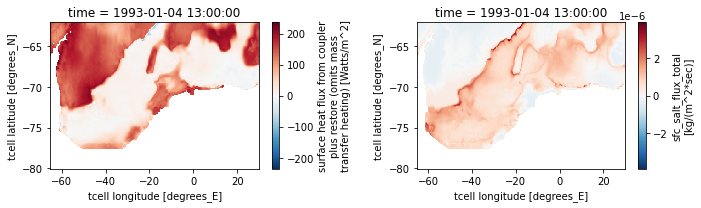

In [263]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ocean_wg.hflux_total[0].plot(ax=ax0)
ocean_wg.salt_flux_total[0].plot(ax=ax1)
plt.tight_layout();

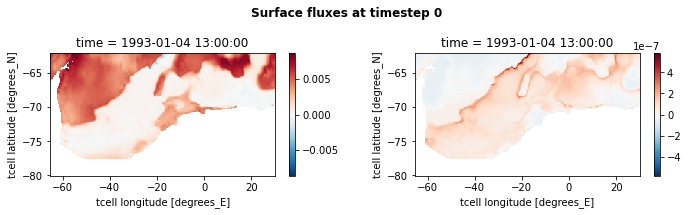

In [264]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

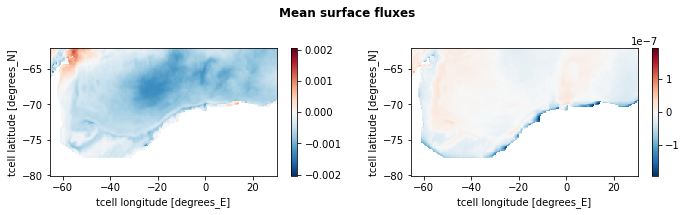

In [265]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

In [270]:
ocean_wg.temp

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [271]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['st_ocean'] = ocean_wg.st_ocean[0]
    da = da.expand_dims(dim='st_ocean', axis=1)
    da, _ = xr.align(da, ocean_wg.st_ocean, join='right')
    return da.fillna(0.)

In [272]:
surf_flux_th

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

In [273]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [274]:
surf_flux_conv_TH

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<where, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

In [275]:
ocean_wg.swflx

<xarray.DataArray 'swflx' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      shortwave flux into ocean (>0 heats ocean)
    standard_name:  surface_net_downward_shortwave_flux
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W/m^2
    valid_range:    [-10000000000.0, 10000000000.0]

In [276]:
#sw flux
sw_flux = (ocean_wg.swflx * dx_interp * dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s

### ^ Need to figure out how to treat swflx penetrating through cell levels
__(PG 252 in MOM5 manual)__

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>